In [1]:
import torch
import triton
import triton.language as tl

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Intuition

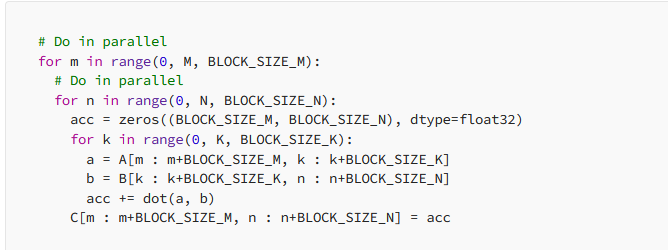

In [22]:
def check_tensors_gpu_ready(*tensors):
    """Check if the tensors are on GPU and with the right dtype."""
    for tensor in tensors:
        assert tensor.is_cuda, "Tensor must be on GPU"
        assert tensor.dtype in [torch.float16, torch.float32], "Tensor must be floating point"

In [23]:
@triton.jit
def naive_matmul(
      A_ptr, B_ptr, C_ptr,
      M, N, K,
      stride_am, stride_ak,
      stride_bk, stride_bn,
      stride_cm, stride_cn,
      BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr):

      pid_m = tl.program_id(axis=0)
      pid_n = tl.program_id(axis=1)

      row_start = BLOCK_SIZE_M * pid_m
      row_indices = row_start + tl.arange(0, BLOCK_SIZE_M)

      col_start = BLOCK_SIZE_N * pid_n
      col_indices = col_start + tl.arange(0, BLOCK_SIZE_N)

      mask_m = row_indices < M
      mask_n = col_indices < N

      acc = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype = tl.float32)

      for k_start in range(0, K, BLOCK_SIZE_K):
          k_indices = k_start + tl.arange(0, BLOCK_SIZE_K)
          mask_k = k_indices < K

          a_ptrs = A_ptr + row_indices[:,None] * stride_am + k_indices[None,:] * stride_ak

          b_ptrs = B_ptr + k_indices[:,None] * stride_bk + col_indices[None,:] * stride_bn

          a = tl.load(a_ptrs, mask = mask_m[:, None] & mask_k[None, : ], other = 0.0)
          b = tl.load(b_ptrs, mask = mask_k[:, None] & mask_n[None, :], other = 0.0)

          acc += tl.dot(a, b)

      c_ptrs = C_ptr + row_indices[:, None] * stride_cm + col_indices[None, :] * stride_cn
      mask_c = mask_m[:, None] & mask_n[None, :]
      tl.store(c_ptrs, acc, mask = mask_c)

In [39]:
def matmul(a, b, matmul_k_fn, bs=16):
    assert a.shape[1] == b.shape[0], "matrix dims not compatible for matmul"
    check_tensors_gpu_ready(a, b)

    (m, k), (_, n) = a.shape, b.shape
    c = torch.empty((m, n), device=a.device, dtype=a.dtype)

    grid = lambda meta: (triton.cdiv(m, bs), triton.cdiv(n, bs))

    matmul_k_fn[grid](
        a, b, c,
        m, n, k,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
        BLOCK_SIZE_M=bs, BLOCK_SIZE_N=bs, BLOCK_SIZE_K=bs,
    )
    return c

In [41]:
device = torch.device('cuda')

# Create example matrices (FP16 for best performance with Tensor Cores)
a = torch.randn((128, 256), device=device, dtype=torch.float16)
b = torch.randn((256, 64), device=device, dtype=torch.float16)

c_triton = matmul(a, b, matmul_k_fn=naive_matmul)

c_torch = torch.matmul(a, b)

assert torch.allclose(c_triton, c_torch, rtol=1e-2, atol=1e-2), "Results don't match!"
print("Triton matmul matches PyTorch matmul!")

Triton matmul matches PyTorch matmul!
